# **Hourly Time Series Forecasting using Meta Prophet**

### Background on the Types of Time Series Data
<img title="TimeSeriesData" alt="timeSereieData" src="../forecast/assets/timeseriesData.jpg">

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

**Mean Absolute Percentage Error (MAPE)** measures the accuracy of a forecasting model by calculating the average absolute percentage difference between predicted and actual values over a series of time periods. It's expressed as a percentage, which makes it easy to interpret, and is particularly useful for comparing model performance accross datasets with different scales. For example, a MAPE of 10% means the average error was 10% of the actual values

$$ MAPE = 100 \frac{1}{n} \sum_{t-1}^n \Bigg|\frac{A_t - F_t}{A_t}\Bigg| $$

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE give y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## **Data**
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up. 

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

```python
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)
```

In [5]:
pjme = pd.read_csv(
    "./data/PJME_hourly.csv",
    index_col=[0],
    parse_dates=[0]
)
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


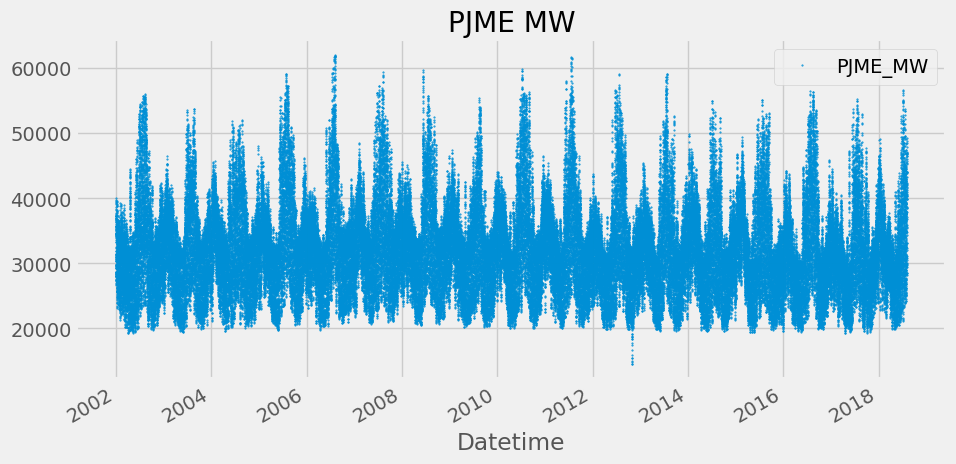

In [6]:
color_pal = sns.color_palette()
pjme.plot(
    style='.',
    figsize=(10, 5), 
    ms=1, 
    color=color_pal[0],
    title="PJME MW"
)

plt.show()

## **Time Sereies Feature**

In [11]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    ordered=True
)

def create_features(df, label=None):
    """ Creates time series features from datetime index."""
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])

    X = df[['hour', 'dayofweek','quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]

    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [12]:
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,Monday,Winter,44284.0
2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,Monday,Winter,43751.0
2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,Monday,Winter,42402.0


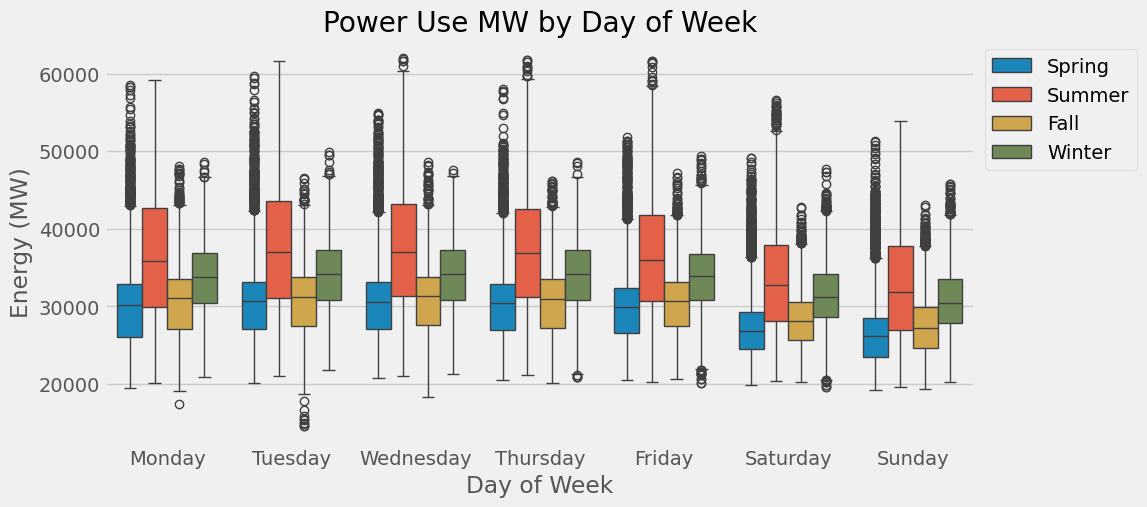

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## **Train / Test Split**

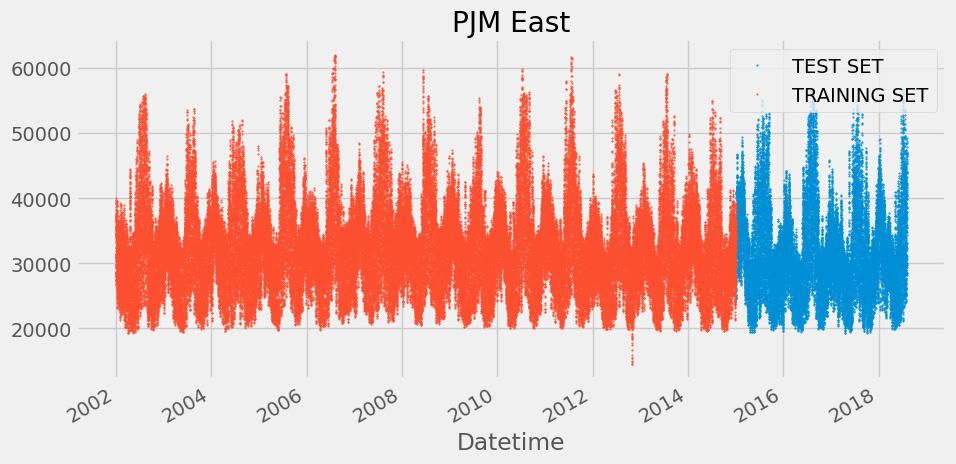

In [18]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test.rename(columns={'PJME_MW': 'TEST SET'}).join(
    pjme_train.rename(
        columns={'PJME_MW':'TRAINING SET'}),
          how='outer').plot(figsize=(10, 5), title="PJM East", style = '.', ms=1)

plt.show()

## **Simple Prophet Model**
* Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding into the model.
  * Datetime column named: $ds$
  * target: $y$

In [19]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index().rename(
    columns={'Datetime':'ds',
             'PJME_MW':'y'})

In [20]:
pjme_train_prophet

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
113922,2014-01-01 20:00:00,36193.0
113923,2014-01-01 21:00:00,35601.0
113924,2014-01-01 22:00:00,34242.0
113925,2014-01-01 23:00:00,32215.0


In [21]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

10:51:58 - cmdstanpy - INFO - Chain [1] start processing
10:52:24 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 2.38 s, sys: 87.6 ms, total: 2.46 s
Wall time: 28.9 s


In [22]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index().rename(
    columns={'Datetime':'ds', 
             'PJME_MW':'y'})
pjme_test_fcst = model.predict(pjme_test_prophet)

In [23]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23824.318755,32730.993762,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,-4430.272423,-4430.272423,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22105.611865,31168.377505,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,-5927.272577,-5927.272577,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21491.205011,30819.435915,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,-6790.346308,-6790.346308,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21155.535701,30260.187677,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,-6922.126021,-6922.126021,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,21704.418953,30636.379714,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,-6237.080479,-6237.080479,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


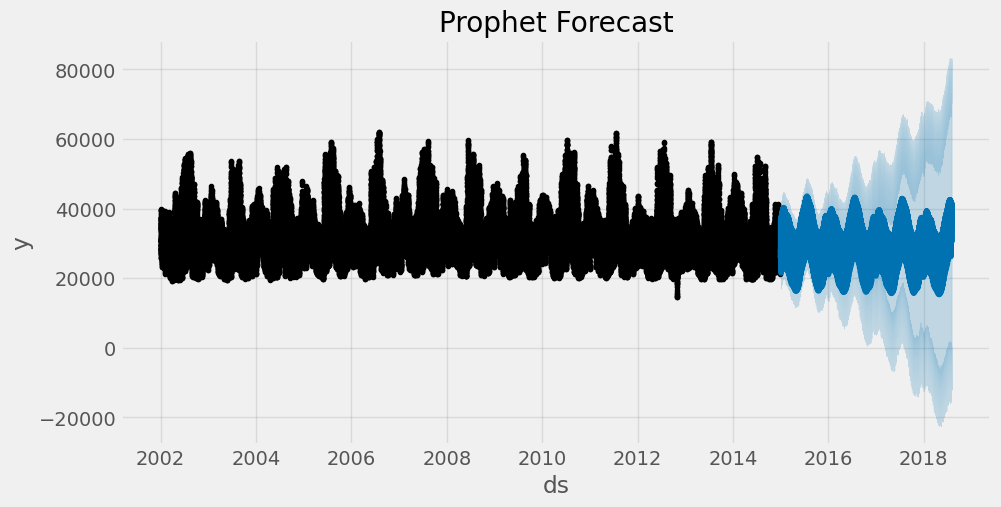

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

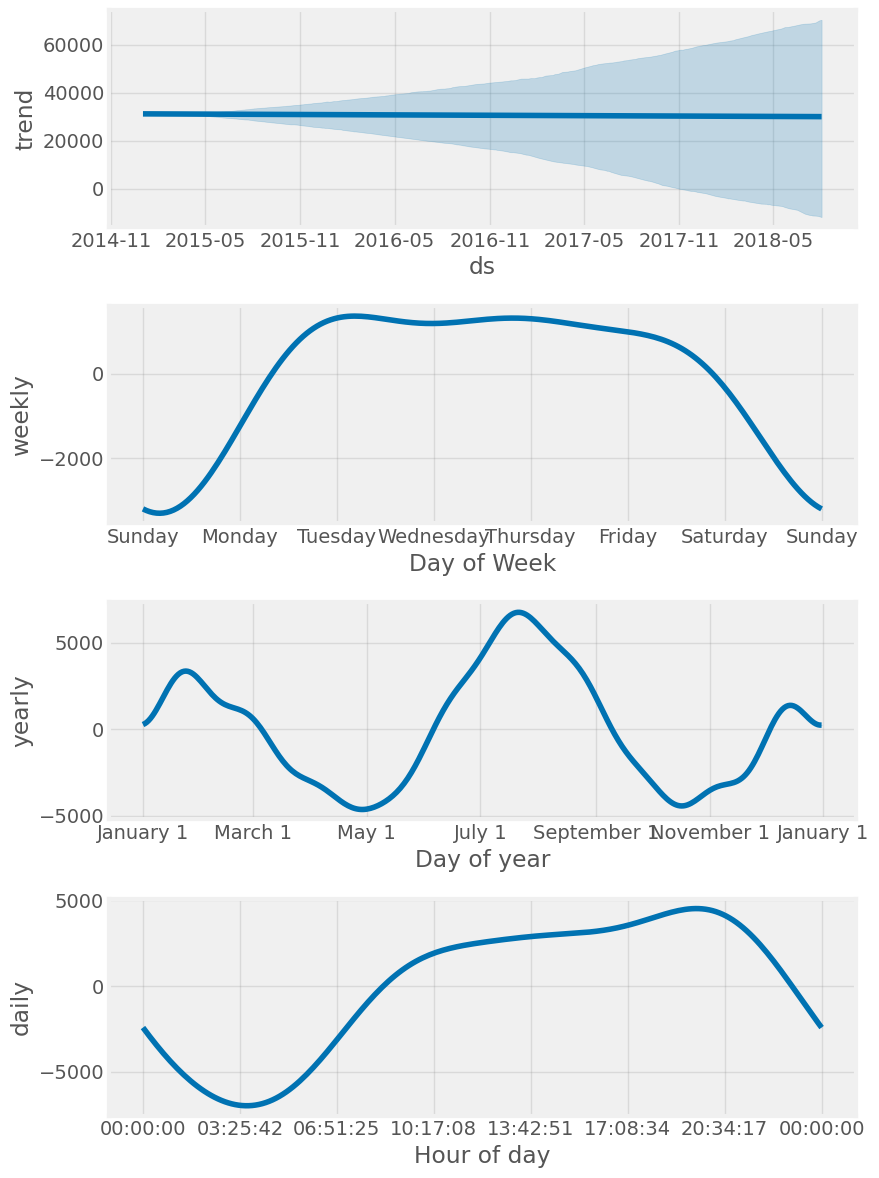

In [25]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

## **Compare Forecast to Actuals**

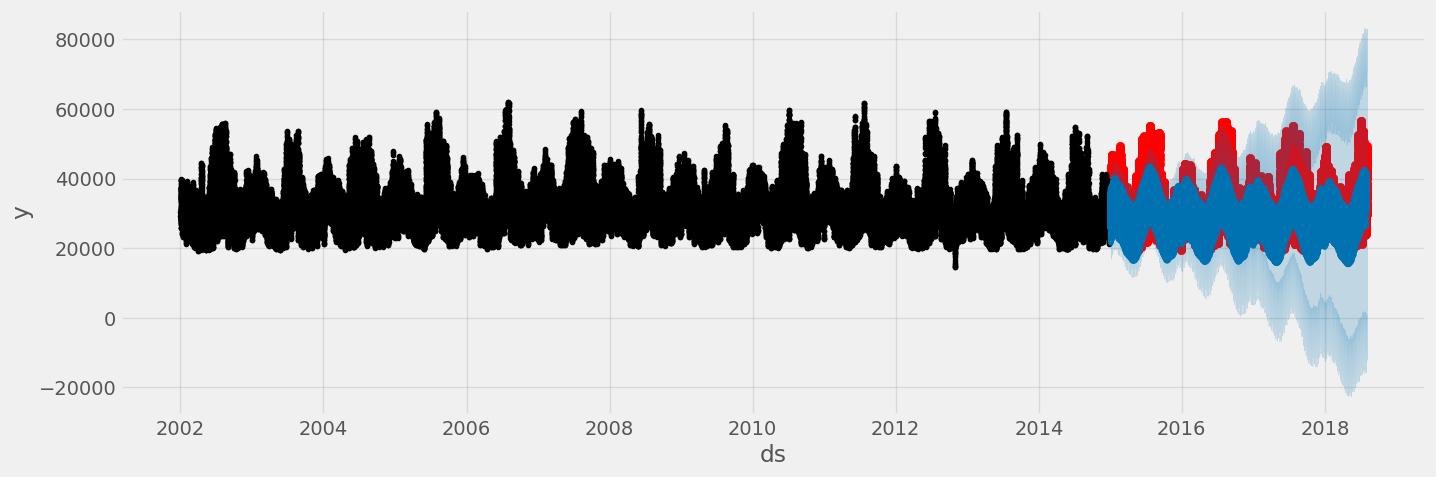

In [29]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

In [ ]:
fig, ax = l